# Heart Attack

# Attribute Information
1) age

2) sex

3) chest pain type (4 values)

4) resting blood pressure

5) serum cholestoral in mg/dl

6)fasting blood sugar > 120 mg/dl

7) resting electrocardiographic results (values 0,1,2)

8) maximum heart rate achieved

9) exercise induced angina

10) oldpeak = ST depression induced by exercise relative to rest

11)the slope of the peak exercise ST segment

12) number of major vessels (0-3) colored by flourosopy

13) thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

14) target: 0= less chance of heart attack 1= more chance of heart attack	

importing necessary libraries

In [61]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pickle
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

In [28]:
ha_data=pd.read_csv("heart.csv")
ha_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Check how many unique values each column contains

In [29]:
dict = {}
for i in list(ha_data.columns):
    dict[i] = ha_data[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"])

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
unique count,41,2,4,49,152,2,3,91,2,40,3,5,4,2


# EDA

since the data has fields with numerical values but indicates types like yes=1,no=0 (categorical values {niminal ,ordinal}), we need to split the data to do some EDA on each feature.

In [30]:
categorical_x = ['sex','exang','ca','cp','fbs','restecg','slope','thal']
continuous_x = ["age","trestbps","chol","thalach","oldpeak"]
y = ["output"]

1-we're gonna use count plot with categorical values 

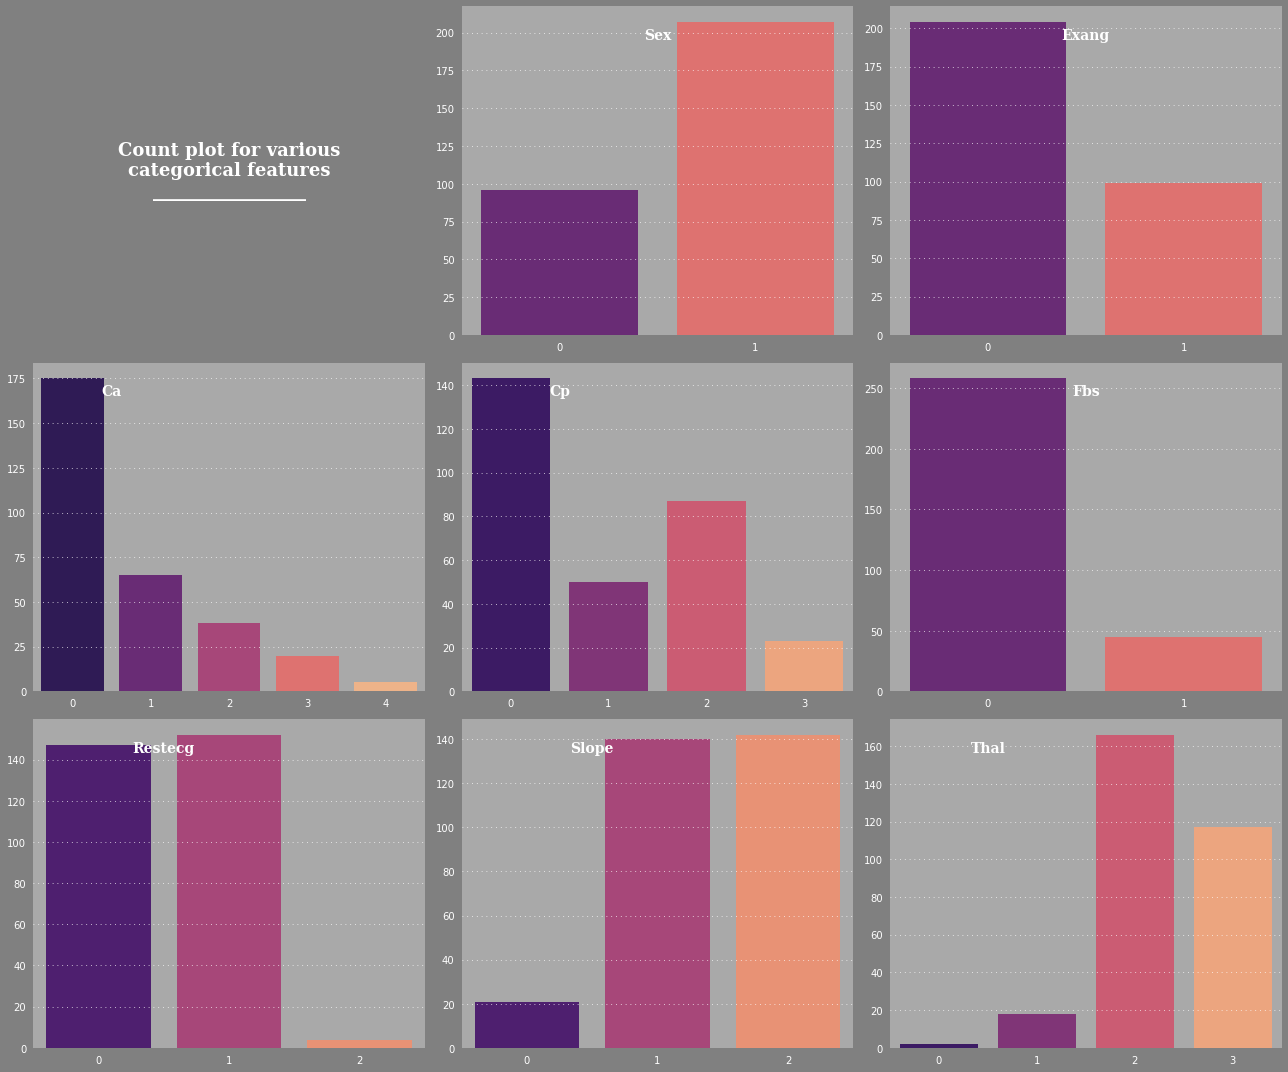

In [31]:
def set_plot_style(ax, title):
    """
    description: Sets the style for each subplot including grid, background color, and axis formatting.
    Input:
        ax: The axis object to apply the style to.
        title: The title to display for the specific plot. 
    Output:
        None. It modifies the style of the given axis.
    """
    ax.grid(color='#ffffff', linestyle=':', axis='y', zorder=0, dashes=(1, 5))  # White dashed grid on Y axis
    ax.set_facecolor("darkgray")  # Dark background for each subplot
    ax.text(0.5, ax.get_ylim()[1] * 0.9, title, fontsize=14, fontweight='bold', fontfamily='serif', color="white",
            ha='center')  # Title at the top of each plot
    ax.spines["bottom"].set_visible(False)  # Hide spines for a clean look
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(left=False, bottom=False, colors="white")  # White tick labels
    ax.set_xlabel("")  # No xlabel
    ax.set_ylabel("")  # No ylabel

ha_datacat = ha_data[categorical_x]  

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.patch.set_facecolor("gray")  
titles = ['Sex', 'Exang', 'Ca', 'Cp', 'Fbs', 'Restecg', 'Slope', 'Thal']
# do subplots with count plots for categorical features
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.text(0.5, 0.5, 'Count plot for various\ncategorical features\n_________________',
                horizontalalignment='center', verticalalignment='center',
                fontsize=18, fontweight='bold', fontfamily='serif', color="white")
        ax.axis('off')  
    elif i <= len(categorical_x): 
        sns.countplot(ax=ax, data=ha_data, x=ha_datacat.columns[i - 1], palette='magma')  
        set_plot_style(ax, titles[i - 1])  
    else:
        ax.axis('off')  
plt.tight_layout()
plt.show()


identifying class imbalances like (sex,fbs,exang), model may be biased towards majority classes so instead of accuracy, i will consider metrics like precision, recall, F1-score.

plot histogram of continuous features

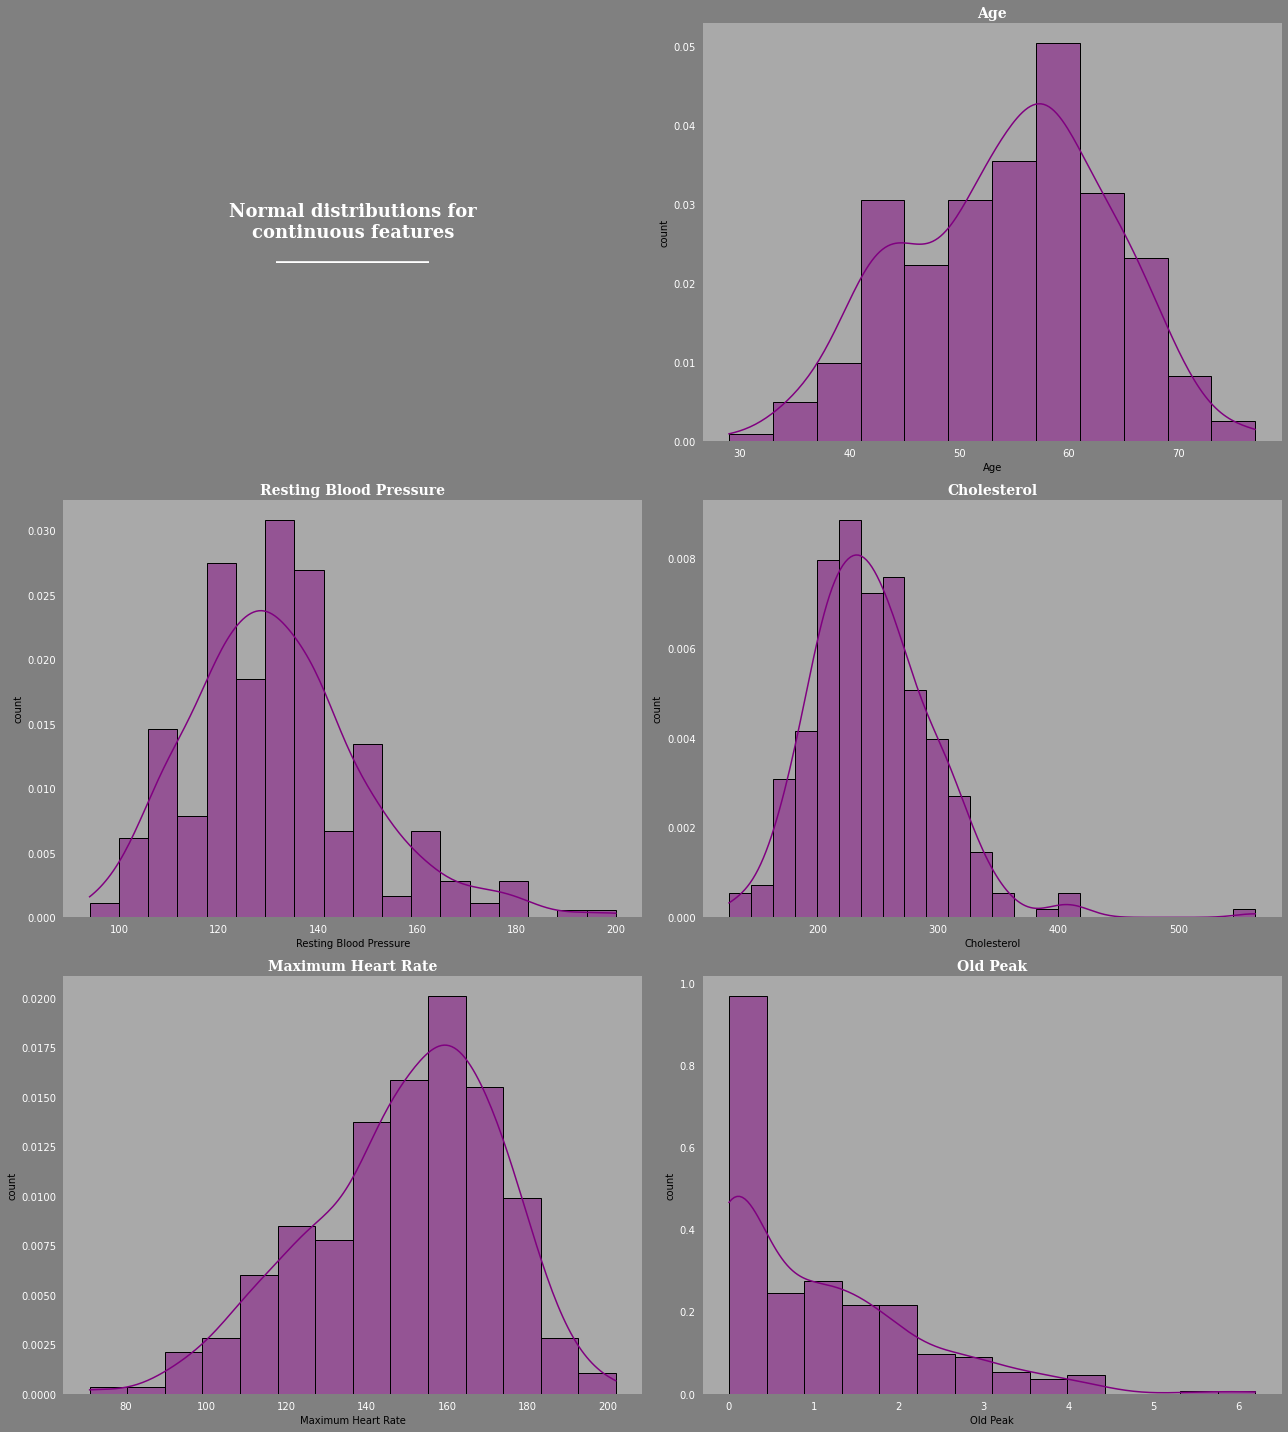

In [37]:
 def set_distribution_style(ax, title):
    """
    This function sets the appearance of each subplot, including background color, title,
    and axis formatting (removes spines, hides ticks, and adjusts labels).

    Input:
        ax: The axis object to modify (from the subplot grid).
        title: The title to be displayed at the top of the subplot.
    
    Output:
        None. It directly modifies the axis object style.
    """
    ax.set_facecolor("darkgray")  # Dark gray background for each subplot
    ax.set_title(title, fontsize=14, fontweight='bold', fontfamily='serif', color="white")
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(left=False, bottom=False, colors="white")  # White tick labels
    ax.set_xlabel(title)
    ax.set_ylabel("count")
titles = ['Age', 'Resting Blood Pressure', 'Cholesterol', 'Maximum Heart Rate', 'Old Peak']
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
fig.patch.set_facecolor("gray") 
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.text(0.5, 0.5, 'Normal distributions for\ncontinuous features\n_________________',
                horizontalalignment='center', verticalalignment='center',
                fontsize=18, fontweight='bold', fontfamily='serif', color="white")
        ax.axis('off')
    elif i <= len(continuous_x):  
        sns.histplot(ax=ax, data=ha_data[continuous_x[i - 1]], kde=True, color='purple', stat="density")
        set_distribution_style(ax, titles[i - 1])
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

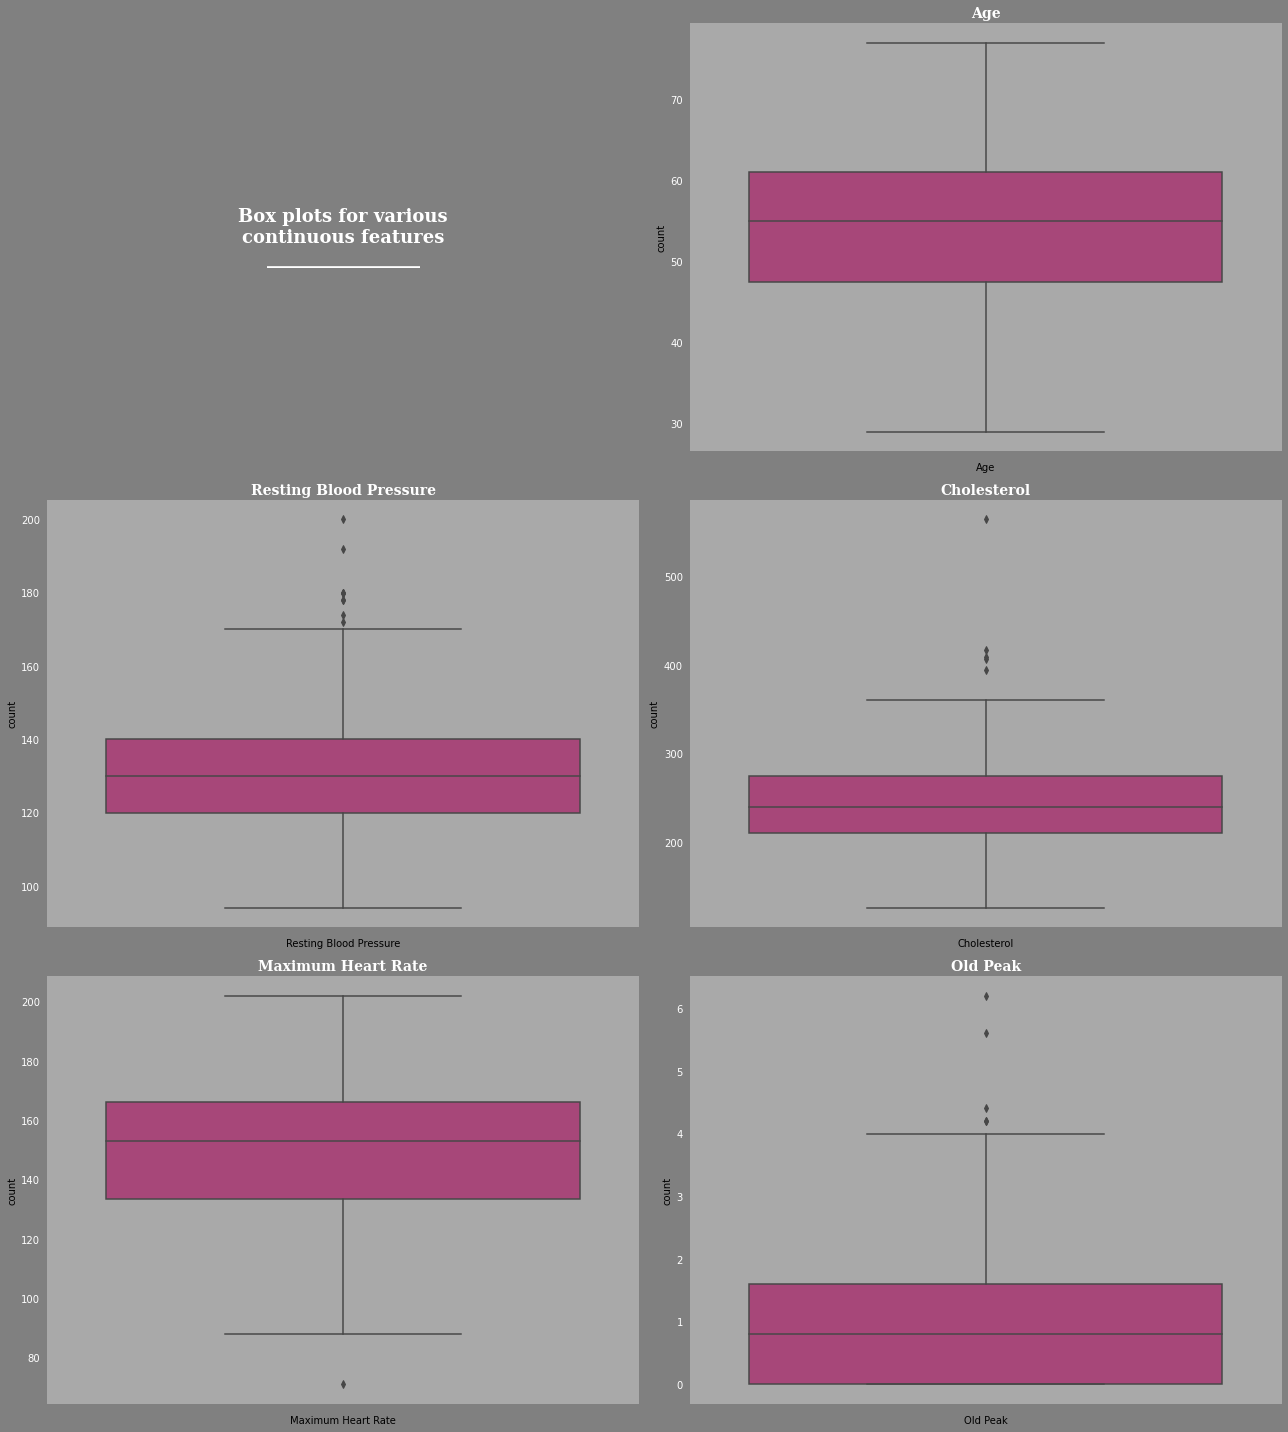

In [38]:
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
fig.patch.set_facecolor("gray")  # Gray background for the entire figure
titles = ['Age', 'Resting Blood Pressure', 'Cholesterol', 'Maximum Heart Rate', 'Old Peak']
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.text(0.5, 0.5, 'Box plots for various\ncontinuous features\n_________________',
                horizontalalignment='center', verticalalignment='center',
                fontsize=18, fontweight='bold', fontfamily='serif', color="white")
        ax.axis('off')
    elif i <= len(continuous_x):  
        sns.boxplot(ax=ax, data=ha_data, y=continuous_x[i - 1], palette='magma')
        set_distribution_style(ax, titles[i - 1])
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()


Age:
The distribution appears relatively symmetric with no significant outliers.
Indicates a balanced age range in the dataset.

Resting Blood Pressure (trestbps):
The data distribution is slightly skewed upward.

Cholesterol (Chol):
Several outliers exist on the higher end (>250 mg/dL), representing potential cases of hypercholesterolemia.
Suggests variability in cholesterol levels across individuals.

Maximum Heart Rate (Thalach):
One or two outliers on the lower end (<100 bpm), which may represent individuals with lower fitness or heart-related conditions.
Overall, the distribution seems normal.

Old Peak (ST Depression):
Outliers (>4 units) indicate individuals with significant ST depression.

Key Insights:
Outliers:
Resting blood pressure, cholesterol, and ST depression show noticeable outliers, which could represent specific subpopulations with extreme conditions.
Health Indicators:

High cholesterol and resting blood pressure levels are risk factors for cardiovascular diseases, as suggested by the data.
Significant variability in the "Old Peak" feature is another potential risk indicator for heart-related conditions.

Balanced Age Distribution:
The age feature indicates a relatively balanced sample across middle-aged individuals.

# correlation between features 

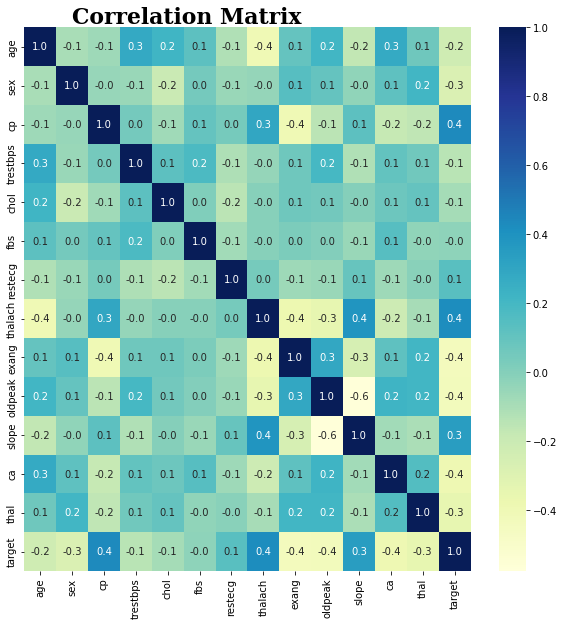

In [12]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(1,1)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])

color_palette = ["#5833ff","#da8829"]

ax0.text(1.5,-0.1,"Correlation Matrix",fontsize=22, fontweight='bold', fontfamily='serif', color="#000000")

df_corr = ha_data.corr().transpose()
sns.heatmap(df_corr,fmt=".1f",annot=True,cmap='YlGnBu')
plt.show()

# Data Cleansing

Check for missing values in the entire dataset

In [13]:
print(ha_data.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


# checking data imbalance

In [14]:
ha_data['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

The dataset is relatively balanced
The difference between the two classes is about 9%, which is generally acceptable and does not qualify as a severe imbalance.

# To avoid data leakage we better split the data before preprocessing it ,but i noticed that the data is ordered which means that all people that have heart attack are on top then those who haven't the disease so we have to shuffle the data then split To avoid any misleading information the model may cause.

In [39]:
shuffeled_data=shuffle(ha_data, random_state=42)
shuffeled_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
179,57,1,0,150,276,0,0,112,1,0.6,1,1,1,0
228,59,1,3,170,288,0,0,159,0,0.2,1,0,3,0
111,57,1,2,150,126,1,1,173,0,0.2,2,1,3,1
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3,0
60,71,0,2,110,265,1,0,130,0,0.0,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,50,1,2,140,233,0,1,163,0,0.6,1,1,3,0
71,51,1,2,94,227,0,1,154,1,0.0,2,1,3,1
106,69,1,3,160,234,1,0,131,0,0.1,1,1,2,1
270,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0


# Data Splitting

In [40]:
X = shuffeled_data.drop(columns=['target']) 
y = shuffeled_data['target']

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # 20% test
X_train,X_valid, y_train,y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)  # 16% valid, 64% train

With startify, we ensure that the proportion of each class in the original dataset is maintained in both the training and test sets because the data is very small.

# Data prepocessing

the features of nominal values are required one hot encoder ('sex','cp','fbs','restecg','exang','ca','thal').

the value of ordinal values are required ordinal or label encoder so i better leave it as it is('slope','thal').

In [41]:
# Nominal and ordinal features
nominal_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca']
ordinal_features = ['slope', 'thal']  # Leave these as-is
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.difference(nominal_features + ordinal_features)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features to avoid the model from being biased 
        ('nom', OneHotEncoder(), nominal_features),     # One-hot encode nominal features
        # Ordinal features are left as-is (no transformation needed)
    ],
    remainder='passthrough'  # Keep ordinal features in the dataset
)

# model building

Logistic Regression model pipeline

In [42]:
logmodel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])
# Train the pipeline
logmodel.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['age', 'chol', 'oldpeak', 'thalach', 'trestbps'], dtype='object')),
                                                 ('nom', OneHotEncoder(),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang',
                                                   'ca'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [43]:
# Evaluate on validation set
y_valid_pred = logmodel.predict(X_valid)
print("Validation Set Performance:")
print(classification_report(y_valid, y_valid_pred))

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        22
           1       0.83      0.89      0.86        27

    accuracy                           0.84        49
   macro avg       0.84      0.83      0.83        49
weighted avg       0.84      0.84      0.84        49



Support Vector Machine (SVM) Model Pipeline

In [44]:
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', random_state=42))  # SVM with linear kernel
])

# Train the SVM pipeline
svm_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['age', 'chol', 'oldpeak', 'thalach', 'trestbps'], dtype='object')),
                                                 ('nom', OneHotEncoder(),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang',
                                                   'ca'])])),
                ('classifier', SVC(kernel='linear', random_state=42))])

In [45]:
# Evaluate SVM on validation set
y_valid_pred_svm = svm_pipeline.predict(X_valid)
print("SVM Validation Set Performance:")
print(classification_report(y_valid, y_valid_pred_svm))

SVM Validation Set Performance:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        22
           1       0.82      0.85      0.84        27

    accuracy                           0.82        49
   macro avg       0.82      0.81      0.81        49
weighted avg       0.82      0.82      0.82        49



Decision Tree Model Pipeline

In [46]:
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5))  # Decision Tree with max depth 5
])

# Train the Decision Tree pipeline
decision_tree_pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['age', 'chol', 'oldpeak', 'thalach', 'trestbps'], dtype='object')),
                                                 ('nom', OneHotEncoder(),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang',
                                                   'ca'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

In [47]:
# Evaluate Decision Tree on validation set
y_valid_pred_dt = decision_tree_pipeline.predict(X_valid)
print("\nDecision Tree Validation Set Performance:")
print(classification_report(y_valid, y_valid_pred_dt))


Decision Tree Validation Set Performance:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        22
           1       0.70      0.70      0.70        27

    accuracy                           0.67        49
   macro avg       0.67      0.67      0.67        49
weighted avg       0.67      0.67      0.67        49



Random forest model pipeline

In [48]:
RFmodel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
# Train the pipeline
RFmodel.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['age', 'chol', 'oldpeak', 'thalach', 'trestbps'], dtype='object')),
                                                 ('nom', OneHotEncoder(),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang',
                                                   'ca'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [49]:
# Evaluate on validation set
y_valid_pred = RFmodel.predict(X_valid)
print("Validation Set Performance:")
print(classification_report(y_valid, y_valid_pred))

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        22
           1       0.85      0.81      0.83        27

    accuracy                           0.82        49
   macro avg       0.81      0.82      0.82        49
weighted avg       0.82      0.82      0.82        49



# model evaluation 

Accuracy:
Useful for balanced datasets 
Precision:
(diagnosing someone as having a heart condition when they don't) are costly or harmful.
Recall (Sensitivity or True Positive Rate):
failing to diagnose a patient with a heart condition) has severe consequences.
F1-Score:
Provides a balanced measure when both precision and recall are important.
Why These Metrics:
Since heart disease detection is a critical application, both precision (avoiding false positives) and recall (identifying all true cases) are essential.
The F1-score ensures a balance between precision and recall.
ROC-AUC gives a comprehensive measure of the classifier's capability to distinguish between the two classes.
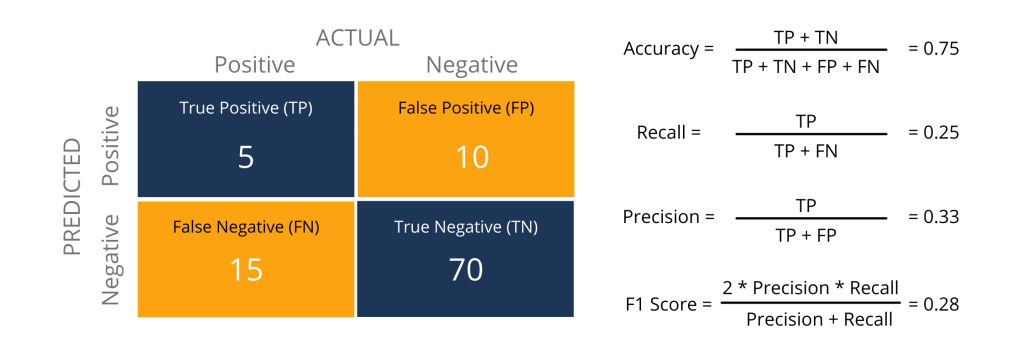

In [50]:
# Final evaluation of logistic on the test set
y_test_pred = logmodel.predict(X_test)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        28
           1       0.91      0.91      0.91        33

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



In [51]:
# Final evaluation of SVM on test set
y_test_pred_svm = svm_pipeline.predict(X_test)
print("SVM Test Set Performance:")
print(classification_report(y_test, y_test_pred_svm))

SVM Test Set Performance:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        28
           1       0.88      0.88      0.88        33

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [52]:
# Final evaluation of Decision Tree on test set
y_test_pred_dt = decision_tree_pipeline.predict(X_test)
print("Decision Tree Test Set Performance:")
print(classification_report(y_test, y_test_pred_dt))

Decision Tree Test Set Performance:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        28
           1       0.77      0.82      0.79        33

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61



In [53]:
# Final evaluation of Random forest on the test set
y_test_pred = RFmodel.predict(X_test)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        28
           1       0.88      0.91      0.90        33

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



1. Macro Average calculates the metrics (precision, recall, F1-score) for each class individually 
and then takes their unweighted mean,so it's useful When all classes are equally important.

2. The weighted average calculates the metrics (precision, recall, F1-score) for each class individually and takes their weighted mean, where the weights are based on the support (number of true samples) for each class.useful when the dataset is slightly imbalanced as this data, and the overall performance matters.

# feature engineering

i tried to do feature engineering by dropping sex feature cause some people say it's important for diagnoses and others said it isnot but what i noticed that there's no difference or progress in the model prediction so i decided to leave it cause it's also biased to males which means i may be important
__so skip this part__

In [30]:
dropsex=shuffeled_data.drop(columns=['sex']) 
X = dropsex.drop(columns=['target']) 
y = dropsex['target']

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # 20% test
X_train,X_valid, y_train,y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)  # 16% valid, 64% train


In [31]:
# Nominal and ordinal features
nominal_features = [ 'cp', 'fbs', 'restecg', 'exang', 'ca']
ordinal_features = ['slope', 'thal']  
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.difference(nominal_features + ordinal_features)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('nom', OneHotEncoder(), nominal_features),     # One-hot encode nominal features
        # Ordinal features are left as it is (no transformation needed)
    ],
    remainder='passthrough'  # Keep ordinal features in the dataset
)

In [32]:
### Decision Tree Model Pipeline
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5))  # Decision Tree with max depth 5
])

# Train the Decision Tree pipeline
decision_tree_pipeline.fit(X_train, y_train)

# Evaluate Decision Tree on validation set
y_valid_pred_dt = decision_tree_pipeline.predict(X_valid)
print("\nDecision Tree Validation Set Performance:")
print(classification_report(y_valid, y_valid_pred_dt))

# Final evaluation of Decision Tree on test set
y_test_pred_dt = decision_tree_pipeline.predict(X_test)
print("Decision Tree Test Set Performance:")
print(classification_report(y_test, y_test_pred_dt))


Decision Tree Validation Set Performance:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        22
           1       0.83      0.70      0.76        27

    accuracy                           0.76        49
   macro avg       0.76      0.76      0.76        49
weighted avg       0.77      0.76      0.76        49

Decision Tree Test Set Performance:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        28
           1       0.79      0.82      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



In [33]:
### Support Vector Machine (SVM) Model Pipeline
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', random_state=42))  # SVM with linear kernel
])

# Train the SVM pipeline
svm_pipeline.fit(X_train, y_train)

# Evaluate SVM on validation set
y_valid_pred_svm = svm_pipeline.predict(X_valid)
print("SVM Validation Set Performance:")
print(classification_report(y_valid, y_valid_pred_svm))

# Final evaluation of SVM on test set
y_test_pred_svm = svm_pipeline.predict(X_test)
print("SVM Test Set Performance:")
print(classification_report(y_test, y_test_pred_svm))



SVM Validation Set Performance:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        22
           1       0.83      0.89      0.86        27

    accuracy                           0.84        49
   macro avg       0.84      0.83      0.83        49
weighted avg       0.84      0.84      0.84        49

SVM Test Set Performance:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        28
           1       0.87      0.82      0.84        33

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



In [34]:
# Random forest model pipeline
RFmodel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
# Train the pipeline
RFmodel.fit(X_train, y_train)
# Evaluate on validation set
y_valid_pred = RFmodel.predict(X_valid)
print("Validation Set Performance:")
print(classification_report(y_valid, y_valid_pred))
# Final evaluation on the test set
y_test_pred = RFmodel.predict(X_test)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        22
           1       0.81      0.81      0.81        27

    accuracy                           0.80        49
   macro avg       0.79      0.79      0.79        49
weighted avg       0.80      0.80      0.80        49

Test Set Performance:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        28
           1       0.86      0.91      0.88        33

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



# for hyperparameter tuning i'm gonna use GridSearchCV on both SVM and Decision Tree. 
# GridSearchCV will help identify the best hyperparameters for these models based on cross-validation since the data is too small. 

Cross-validation is used to:
1. Avoid overfitting by validating the model on unseen data during training.
2. Provide reliable performance estimates by averaging results across multiple splits.
3. Make efficient use of the data by training and validating on different subsets.
4. Robustly select the best hyperparameters by evaluating them on multiple folds.
In GridSearchCV, 5-fold cross-validation ensures the model is trained on 4 folds and validated on 1 fold,
repeating this process 5 times for each hyperparameter combination, reducing bias from a single train-test split.


In [56]:
# Define the parameter grid for SVM
svm_param_grid = {
    'classifier__C': [0.1, 1, 10],  # Regularization strength
    'classifier__kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'classifier__gamma': ['scale', 'auto']  # Kernel coefficient
}

# SVM pipeline with grid search
svm_grid_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

svm_grid_search = GridSearchCV(
    svm_grid_pipeline, param_grid=svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1
)

# Fit the SVM GridSearchCV on the training data
svm_grid_search.fit(X_train, y_train)

# Best parameters and score for SVM
print("Best SVM Parameters:", svm_grid_search.best_params_)
print("Best SVM Cross-Validation Accuracy:", svm_grid_search.best_score_)

# Evaluate SVM on validation and test sets
y_valid_pred_svm = svm_grid_search.best_estimator_.predict(X_valid)
y_test_pred_svm = svm_grid_search.best_estimator_.predict(X_test)

print("\nSVM Validation Set Performance:")
print(classification_report(y_valid, y_valid_pred_svm))

print("SVM Test Set Performance:")
print(classification_report(y_test, y_test_pred_svm))



Best SVM Parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best SVM Cross-Validation Accuracy: 0.8295546558704453

SVM Validation Set Performance:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        22
           1       0.83      0.89      0.86        27

    accuracy                           0.84        49
   macro avg       0.84      0.83      0.83        49
weighted avg       0.84      0.84      0.84        49

SVM Test Set Performance:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88        28
           1       0.91      0.88      0.89        33

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61



In [57]:

# Define the parameter grid for Decision Tree
dt_param_grid = {
    'classifier__max_depth': [3, 5, 10, None],  # Tree depth
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples to split
    'classifier__min_samples_leaf': [1, 2, 5]  # Minimum samples in a leaf
}

# Decision Tree pipeline with grid search
dt_grid_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_grid_search = GridSearchCV(
    dt_grid_pipeline, param_grid=dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1
)

# Fit the Decision Tree GridSearchCV on the training data
dt_grid_search.fit(X_train, y_train)

# Best parameters and score for Decision Tree
print("\nBest Decision Tree Parameters:", dt_grid_search.best_params_)
print("Best Decision Tree Cross-Validation Accuracy:", dt_grid_search.best_score_)

# Evaluate Decision Tree on validation and test sets
y_valid_pred_dt = dt_grid_search.best_estimator_.predict(X_valid)
y_test_pred_dt = dt_grid_search.best_estimator_.predict(X_test)

print("\nDecision Tree Validation Set Performance:")
print(classification_report(y_valid, y_valid_pred_dt))

print("Decision Tree Test Set Performance:")
print(classification_report(y_test, y_test_pred_dt))


Best Decision Tree Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best Decision Tree Cross-Validation Accuracy: 0.7520917678812415

Decision Tree Validation Set Performance:
              precision    recall  f1-score   support

           0       0.59      0.59      0.59        22
           1       0.67      0.67      0.67        27

    accuracy                           0.63        49
   macro avg       0.63      0.63      0.63        49
weighted avg       0.63      0.63      0.63        49

Decision Tree Test Set Performance:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        28
           1       0.77      0.82      0.79        33

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61



# Ensemble learning

the data is very small so i will try to split it as train and test data only with ensemble learning 

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logmodel = logmodel 
RFmodel = RFmodel   
svm_model = svm_grid_search  
dt_model = dt_grid_search  
ensemble_model = VotingClassifier(estimators=[
    ('logmodel', logmodel),
    ('rf', RFmodel),
    ('svm', svm_model),
    ('dt', dt_model)
], voting='hard')  
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Ensemble Model Accuracy: {accuracy:.4f}')


Ensemble Model Accuracy: 0.8352


# The best accuracy and f1 score is 90% logistic regression on test data
# But I will save all models to compare results

# save models as a pickle files

In [58]:
models = {
    'LOGmodel.pkl': logmodel,
    'RFmodel.pkl': RFmodel,
    'SVMmodel.pkl': svm_grid_search,
    'DTmodel.pkl': dt_grid_search
}
for model_filename, model in models.items():
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
print("models are saved successfully.")

models are saved successfully.


In [61]:
# trying to predict fictional data
def predict_single_row(pipeline, row):
    """
    Predicts the outcome (0 or 1) for a single row of data.

    Parameters:
        pipeline: The trained pipeline (including preprocessing and the model).
        row: A dictionary or pandas Series containing the input data (single row).

    Returns:
        int: The predicted class (0 or 1).
    """
    row_df = pd.DataFrame([row])
    prediction = pipeline.predict(row_df) 
    return int(prediction[0])
example_row = {
    'age': 52,
    'sex': 1,
    'cp': 2,
    'trestbps': 140,
    'chol': 233,
    'fbs': 1,
    'restecg': 0,
    'thalach': 165,
    'exang': 0,
    'oldpeak': 1.5,
    'slope': 2,
    'ca': 0,
    'thal': 2
}
# Predict the result
result = predict_single_row(RFmodel, example_row)
print(f"Predicted Result: {result}")

Predicted Result: 1
